## Vokabularienvergleich

In [39]:
import csv
import json
import nltk
from tabulate import tabulate
from collections import Counter
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

### Überblick über Daten

- **ACDH-CH-Website** - https://www.oeaw.ac.at/acdh (Tags bei Projekten und Tools)
- **ARCHE** - https://arche.acdh.oeaw.ac.at (hasAppliedMethod, hasSubject, hasCategory)
- **DARIAH Campus** - https://campus.dariah.eu/ (Topics bei Resources)
- **dha** - https://digital-humanities.at/de/dha/projects (Tags bei Projekten)
- **HowTo des ACDH-CH** - https://howto.acdh.oeaw.ac.at (Tags bei Posts)
- **GAMS** - https://gams.uni-graz.at/ (Tags/Keywords für Filter)
- **TaDiRAH** - https://vocabs.dariah.eu/tadirah/en/
- **TaDiRAH-Products** (modifizierte Variante, in Graz in Arbeit)
- **Zotero von KONDE** - https://www.zotero.org/groups/1332658/konde (manuelle und automatische Tags zu Sekundärliteratur)


### Datenimport

In [2]:
#Import der manuell ergänzten Version der Tags des ACDH-CH HowTo (ht)
#zusätzliche Informationen: Description, Count

with open("HowTo_ergänzt.json", encoding = "utf-8") as datei:
    ht_orig = json.load(datei)

print(ht_orig)

{'Datenmanagement': {'description': 'Datenmanagement', 'count': '4'}, 'Prosopographic data': {'description': 'Prosopographic data', 'count': '4'}, 'Semantic web': {'description': 'Semantic web', 'count': '4'}, 'Lexicography': {'description': 'The theory and practice of compiling dictionaries.', 'count': '1'}, 'Linguistics': {'description': 'Linguistics', 'count': '1'}, 'UI design': {'description': 'UI (user interface) design', 'count': '1'}, 'TEI': {'description': 'TEI', 'count': '1'}, 'Ontology': {'description': 'An ontology represents entities, data and ideas through the definition of categories, their properties, their interdependencies and relations, that show how the concepts, data and entities are related to a particular subject area, i.e. discourse. An ontology limits the complexity of a subject area and groups data into information and knowledge. When a controlled vocabulary is used to talk about the information and knowledge that are represented in an ontology, communication i

In [3]:
#Import von DARIAH-Campus (dc)
#zusätzliche Informationen: Count

with open("DARIAH-Campus_Topics.json", encoding = "utf-8") as datei:
    dc_orig = json.load(datei)

print(dc_orig)

{'Research infrastructures': '35', 'Data management': '26', 'DH': '22', 'Open science': '21', 'eHeritage': '20', 'Training and education': '19', 'Digital Archives': '14', 'Open access': '13', 'Scholarly editions': '10', 'Scholarly practice': '8', 'Data visualisation': '7', 'Citizen science': '6', 'EOSC': '6', 'Multimodality': '6', 'Computational Imaging': '4', 'Data modeling': '4', 'Design Thinking': '4', 'Open education': '4', 'Project management': '4', 'Repositories & Collections': '4', 'Sustainability': '4', 'TEI': '4', 'XML': '4', 'Feminism': '3', 'Lexicography': '3', 'Metadata': '3', 'Scholarly publishing': '3', 'Source Criticism': '3', 'Spatial humanities': '3', 'Augmented reality': '2', 'Big data': '2', 'Controlled Vocabularies': '2', 'History of Technology': '2', 'Ontologies': '2', 'Semantic Web': '2', 'Software development': '2', 'Sound studies': '2', 'Editing tools': '1', 'Game Studies': '1', 'Geotagging': '1', 'Information Architecture': '1', 'Literacies': '1', 'Machine Lear

In [4]:
#Import der Tags der ACDH-CH-Website (acdh)
#zusätzliche Informationen: Count für Tools, Count für Projekte, Count insgesamt

acdh_orig = {}

with open("Tags_ACDH-CH-Website.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        count_tools = element[1]
        count_projects = element[2]
        count = element[3]
        if tag == "\ufeffTag" or tag == "Summe":
            continue
        else:
            acdh_orig[tag] = {"count_tools": count_tools, "count_projects": count_projects, "count": count}

print(acdh_orig)

{'aesthetics of music': {'count_tools': '0', 'count_projects': '2', 'count': '2'}, 'annotation': {'count_tools': '2', 'count_projects': '4', 'count': '6'}, 'archaeology': {'count_tools': '1', 'count_projects': '7', 'count': '8'}, 'austrian music studies': {'count_tools': '0', 'count_projects': '17', 'count': '17'}, 'citizen science': {'count_tools': '0', 'count_projects': '2', 'count': '2'}, 'codicology': {'count_tools': '0', 'count_projects': '4', 'count': '4'}, 'corpora': {'count_tools': '3', 'count_projects': '10', 'count': '13'}, 'corpus linguistics': {'count_tools': '2', 'count_projects': '14', 'count': '16'}, 'critical editions of music': {'count_tools': '0', 'count_projects': '4', 'count': '4'}, 'cultural heritage': {'count_tools': '0', 'count_projects': '16', 'count': '16'}, 'cultural history': {'count_tools': '4', 'count_projects': '17', 'count': '21'}, 'cultural studies': {'count_tools': '0', 'count_projects': '1', 'count': '1'}, 'culture studies': {'count_tools': '0', 'count

In [5]:
#Import der ARCHE-Tags (hasSubject + hasAppliedMethod + hasCategory)
#zusätzliche Informationen: Count, Property
#Behandlung der drei Properties als drei verschiedene Vokabularien

arche_hasSubject_orig = {}
arche_hasAppliedMethod_orig = {}
arche_hasCategory_orig = {}
counter = 0

with open("ARCHE_erweitert_2022-09-29.csv", encoding = "utf-8") as datei:
    for row in datei:
        counter = counter + 1
        element = row.replace("Ã¤", "ä").replace("Ã¶", "ö").replace("Ã¼", "ü").replace("ÃŸ", "ß").replace("Ã–", "Ö").replace("Ã„", "Ä").replace("Ãœ", "Ü").replace("Ã¡", "á").replace("ÄŸ", "ğ").replace("Ã©", "é").strip().split(";")
        if element[0] == "\ufeffsubject":
            continue
        else:
            tag = element[0]
            count = element[1]
            if element[2] == "hasSubject":
                arche_hasSubject_orig[tag] = count
            elif element[2] == "hasAppliedMethod":
                arche_hasAppliedMethod_orig[tag] = count
            elif element[2] == "hasCategory":
                arche_hasCategory_orig[tag] = count
            else:
                print("Fehler - unbekannte Kategorie: " + element[2] + " (Zeile: " + str(counter) + ")")

#manuelle Aufnahme von einem Fall mit ";" innerhalb von subject (s. Fehlermeldung im Output)
arche_hasSubject_orig["25er-Ausschuss; Fünfundzwanziger-Ausschuss"] = 1

print(arche_hasSubject_orig)
print(arche_hasAppliedMethod_orig)
print(arche_hasCategory_orig)

Fehler - unbekannte Kategorie: 1 (Zeile: 572)
{'Postkarte': '44', 'Militarismus': '9', 'spelling conventions': '1', 'Durchschlag mit handschriftlicher Mitteilung': '4', 'material culture': '2', 'archaeological sites': '1', 'Grabungstagebuch': '1', 'Fundbearbeitung': '2', 'deutschösterr. Regierung': '19', 'D.J.KLB': '6', 'E.F.GEL': '2', 'question-answer session': '32', 'D.J.REK': '4', 'Einspruch': '6', 'research event': '3', 'D.K.AAS': '2', 'Zeugenaussage': '11', 'T.F.AUS': '1', 'Klage wegen Forderung': '1', 'Brief': '2293', 'Zeitungsartikel': '354', 'Grand Principality': '1', 'Mörtelproben': '1', 'Mitteilung': '37', 'R.F.PRE': '69', 'T.F.UNA': '1', 'language variation': '1', 'Mitschriften': '2', 'D.K.BRF': '2293', 'Intertextualität': '11', 'Commissary District': '4', 'D.J.BRF': '12', 'T.F.VER': '1', 'D.J.BIT': '22', 'Persönlichkeitsrechtsverletzung': '1', 'T.F.FZA': '2', 'bibliography': '7', 'Verletzung des Rechts am eigenen Bild': '1', 'Originalmappe': '292', 'None': '4', 'D.J.PKL': '

In [6]:
#Import der dha-Tags
#Notiz: eine Dopplung ("political science" zweimal, mit je Count = 1) direkt im .csv korrigiert

dha_orig = {}

with open("dha-tags-count_20220928.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(",")
        if element[0] == "Name":
            continue
        else: 
            tag = element[0]
            count = element[1]
            dha_orig[tag] = count

#manuelle Korrektur eines Eintrags mit Beistrichen im Tag
del dha_orig["Formats"]
dha_orig["Formats, Protocols, Standards"] = 1

print(dha_orig)

{'16th Century': '2', '17th Century': '2', '18th Century': '8', '19th Century': '3', '3D': '3', 'address': '1', 'Aldersbach abbey': '1', 'algorithms': '2', 'analyser': '3', 'ancient greek': '1', 'ancient history': '4', 'annotation': '13', 'antiquity': '1', 'API': '1', 'applied humanities': '4', 'archaeology': '17', 'architecture': '2', 'archival description': '1', 'archives': '16', 'ARIADNE': '1', 'art': '3', 'art driven innovation': '4', 'art history': '5', 'art science': '3', 'art studies': '1', 'artificial intelligence': '3', 'artisitc actionism': '1', 'artistic actionism': '2', 'artistic activism': '2', 'astronomy': '1', 'audio recordings': '8', 'audio-visual': '1', 'augmented reality': '1', 'Austria': '5', 'Austrian Academy of Sciences': '1', 'automation': '1', 'Bauforschung': '1', 'Belarus': '1', 'biases': '1', 'bibliography': '2', 'bioarchaeology': '2', 'biodiversity': '1', 'biographies': '1', 'Buddhism': '1', 'burials': '1', 'cataloguing': '2', 'Central Asia': '1', 'CfA': '3', 

In [7]:
#Import der Tags der ACDH-CH-Website (acdh)
#zusätzliche Informationen: Count für Tools, Count für Projekte, Count insgesamt

acdh_orig = {}

with open("Tags_ACDH-CH-Website.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        count_tools = element[1]
        count_projects = element[2]
        count = element[3]
        if tag == "\ufeffTag" or tag == "Summe":
            continue
        else:
            acdh_orig[tag] = {"count_tools": count_tools, "count_projects": count_projects, "count": count}

print(acdh_orig)

{'aesthetics of music': {'count_tools': '0', 'count_projects': '2', 'count': '2'}, 'annotation': {'count_tools': '2', 'count_projects': '4', 'count': '6'}, 'archaeology': {'count_tools': '1', 'count_projects': '7', 'count': '8'}, 'austrian music studies': {'count_tools': '0', 'count_projects': '17', 'count': '17'}, 'citizen science': {'count_tools': '0', 'count_projects': '2', 'count': '2'}, 'codicology': {'count_tools': '0', 'count_projects': '4', 'count': '4'}, 'corpora': {'count_tools': '3', 'count_projects': '10', 'count': '13'}, 'corpus linguistics': {'count_tools': '2', 'count_projects': '14', 'count': '16'}, 'critical editions of music': {'count_tools': '0', 'count_projects': '4', 'count': '4'}, 'cultural heritage': {'count_tools': '0', 'count_projects': '16', 'count': '16'}, 'cultural history': {'count_tools': '4', 'count_projects': '17', 'count': '21'}, 'cultural studies': {'count_tools': '0', 'count_projects': '1', 'count': '1'}, 'culture studies': {'count_tools': '0', 'count

In [35]:
#Import der TaDiRAH-Tags
#zusätzliche Information: Synonym, falls es sich bei Tag um alternative Bezeichnung handelt (z.B. OCR --> Optical Character Recognition)

tadirah_orig = {}

with open("TaDiRAH.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        synonym = element[1] 
        if tag == "\ufeffTag":
            continue
        else:
            tadirah_orig[tag] = {"synonym": synonym}

print(tadirah_orig)

{'Abstract Thinking': {'synonym': ''}, 'Academic Publishing': {'synonym': ''}, 'Adding': {'synonym': ''}, 'Aggregating': {'synonym': ''}, 'Analyzing': {'synonym': ''}, 'Annotating': {'synonym': ''}, 'Archiving': {'synonym': ''}, 'Associate': {'synonym': ''}, 'Associating': {'synonym': ''}, 'Audio Annotation': {'synonym': ''}, 'Audio Conferencing': {'synonym': ''}, 'Audio Recording': {'synonym': ''}, 'Authorship Attribution': {'synonym': ''}, 'Bit Stream Preservation': {'synonym': ''}, 'Blogging': {'synonym': ''}, 'Browsing': {'synonym': ''}, 'Capturing': {'synonym': ''}, 'Cataloging': {'synonym': ''}, 'Cluster Analysis': {'synonym': ''}, 'Co-Occurrence': {'synonym': ''}, 'Collaborating': {'synonym': ''}, 'Collating': {'synonym': ''}, 'Collecting': {'synonym': ''}, 'Collocation Analysis': {'synonym': ''}, 'Commenting': {'synonym': ''}, 'Communicating': {'synonym': ''}, 'Comparing': {'synonym': ''}, 'Compiling': {'synonym': ''}, 'Conceptualizing': {'synonym': ''}, 'Concordance': {'synony

In [43]:
#Import der TaDiRAH-Product-Tags
#zusätzliche Information: Level in Tadirah, Synonym, gemappter Terminus in dha, gemappter Terminus in Wikidata

tadirah_prod_orig = {}

with open("TaDiRAH_products.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[1].strip("()?") #aktuell noch Klammern und Fragezeichen im GoogleSheet - hier herausgelöscht
        level = element[2] #Level in Tadirah (wenn ein Tag auf mehreren Leveln vorkommt, werden diese in einer Liste gesammelt)
        synonym = element[3] #etwaige eingetragene Synonyme - z.B. Addition zu Adding
        dha_match = element[4] #gemappter Terminus im dha-Tagset
        #hier noch wiki-data-match einfügen (sobald in csv übertragen)
        if tag == "Tag" or tag == "":
            continue
        else:
            if tag not in tadirah_prod_orig.keys():
                tadirah_prod_orig[tag] = {"level": [level], "synonym": synonym, "dha_match": dha_match}
            else:
                tadirah_prod_orig[tag]["level"].append(level)

print(tadirah_prod_orig)

{'Browsing': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Capturing': {'level': ['1'], 'synonym': '', 'dha_match': ''}, 'Crowdsourcing': {'level': ['2'], 'synonym': '', 'dha_match': ''}, 'Exploration': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Graphics Programming': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Parsing': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Transcoding': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Web Crawling': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Web Scraping': {'level': ['3', '4', '3'], 'synonym': '', 'dha_match': ''}, 'Abstract Thinking': {'level': [''], 'synonym': '', 'dha_match': ''}, 'Academic Publication': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Adding': {'level': ['3'], 'synonym': 'Addition', 'dha_match': ''}, 'Aggregation': {'level': ['3'], 'synonym': '', 'dha_match': ''}, 'Analysis': {'level': ['1'], 'synonym': '', 'dha_match': ''}, 'Annotation': {'level': ['2'], 'synonym': '', 'dha_match': 'A

In [45]:
#Vergleich von TaDiRAH (Original: Fokus auf Aktivitäten) und TaDiRAH-Produkt-Variante

both = []
processes_only = []
products_only = [] #modifizierte Variante

for key in tadirah_orig.keys():
    if key in tadirah_prod_orig.keys():
        both.append(key)
    else:
        processes_only.append(key)

for key in tadirah_prod_orig.keys():
    if key not in tadirah_orig.keys():
        products_only.append(key)

print("beide:", len(both))
print("nur bei Produkten (Graz-Variante):", len(products_only))
print("nur bei Prozessen (Original):", len(processes_only))

products_only.sort() #alphabetische Sortierung für besseren Überblick
online_only.sort()

print()
print("nur bei Produkten (Graz-Variante):", products_only)
print()
print("nur bei Prozessen (Original):", processes_only)

beide: 109
nur bei Produkten (Graz-Variante): 62
nur bei Prozessen (Original): 69

nur bei Produkten (Graz-Variante): ['Academic Publication', 'Aggregation', 'Analysis', 'Annotation', 'Archive', 'Association', 'Audio Conference', 'Audio File', 'Blog', 'Catalogue', 'Collaboration', 'Collation', 'Collection', 'Comment', 'Communication', 'Comparison', 'Compilation', 'Context', 'Conversion', 'Creation', 'Data Ingest', 'Data Migration', 'Design', 'Diagramm', 'Digital Publication', 'Discovery', 'Discussion', 'Dissemination', 'E-mail', 'Encoding/Code', 'Enrichment', 'Georeference', 'Identification', 'Image', 'Instant Message', 'Integration', 'Interpretation', 'Lemmatization', 'Map', 'Microblog', 'Mind Map', 'Organisation', 'POS Tag', 'Photograph', 'Plot', 'Preservation', 'Programm', 'Pseudo Code', 'Publication', 'Query', 'Scan', 'Search', 'Segmentation', 'Social Network', 'Speech recognition', 'Storage', 'Text Message', 'Transcription', 'Translation', 'Version', 'Video', 'Wireframe']

nur bei

In [56]:
#Import der Tags von KONDE-Zotero-Gruppe
#aktuell keine zusätzlichen Informationen

zotero_orig = {}

##Extraschritt bei Zotero: Cleaning von metatextuellen Markierungen folgender Art:
metamarkierungen = ["act_", "activity: ", "meta_", "university: ", "type: ", "t_", "obj_", "object: ", "goal_", "field: ", "supervisor: "]

with open("Zotero.csv", encoding = "utf-8") as datei:
    for row in datei:
        tag = row.strip("\ufeff").strip() #kein Split nötig, da nur eine Spalte mit Tags
        for markierung in metamarkierungen:
            tag = tag.replace(markierung, "")
        zotero_orig[tag] = {} #in Zukunft noch weitere Informationen hinzufügbar

print(zotero_orig)

{'550 Geowissenschaften': {}, 'academia': {}, 'academic': {}, 'academics': {}, 'Acceso': {}, 'Annotating': {}, 'Archiving': {}, 'Collaborating': {}, 'Communicating': {}, 'Conceptualizing': {}, 'ContentAnalysis': {}, 'Conversion': {}, 'Crowdsourcing': {}, 'DataRecognition': {}, 'Discovering': {}, 'Editing': {}, 'Identifying': {}, 'Imaging': {}, 'Modeling': {}, 'NetworkAnalysis': {}, 'Organizing': {}, 'Preservation': {}, 'Programming': {}, 'Publishing': {}, 'Query/Retrieve': {}, 'RelationalAnalysis': {}, 'Sharing': {}, 'StructuralAnalysis': {}, 'StylisticAnalysis': {}, 'Teaching/Learning': {}, 'Theorizing': {}, 'Transcription': {}, 'Visualizing': {}, 'Writing': {}, 'ACTIVE learning': {}, 'activism': {}, 'Analyze qualitatively': {}, 'Analyze quantitatively': {}, 'Annotate': {}, 'Assess': {}, 'Authenticate': {}, 'Collaborate': {}, 'Collect': {}, 'Compare': {}, 'Conceptualize': {}, 'Create': {}, 'Digitize': {}, 'Encode': {}, 'Enrich': {}, 'Gather': {}, 'Interpret': {}, 'Reflect': {}, 'Simul

In [57]:
#Import der Tags von GAMS
#zusätzliche Informationen: Sprache (de/en), Kategorie (Disziplin/Thema/Quellenmaterial/Methode/Periode), ID (selbst hinzugefügt, um Übersetzungen wiederzufinden)

gams_orig = {}

with open("GAMS.csv", encoding = "utf-8") as datei:
    for row in datei:
        element = row.strip().split(";")
        tag = element[0]
        lang = element[1] #Sprache
        cat = element[2] #Kategorie
        id = element[3] #ID
        if tag == "\ufeffTag":
            continue
        else:
            gams_orig[tag] = {"lang": lang, "cat": cat, "id": id}

print(gams_orig)

{'Geschichte': {'lang': 'de', 'cat': 'Disziplin', 'id': '1'}, 'Archäologie': {'lang': 'de', 'cat': 'Disziplin', 'id': '2'}, 'Kunstgeschichte': {'lang': 'de', 'cat': 'Disziplin', 'id': '3'}, 'Kulturerbe': {'lang': 'de', 'cat': 'Disziplin', 'id': '4'}, 'Geschlechter Studien': {'lang': 'de', 'cat': 'Disziplin', 'id': '5'}, 'Linguistik': {'lang': 'de', 'cat': 'Disziplin', 'id': '6'}, 'Sprachwissenschaften': {'lang': 'de', 'cat': 'Disziplin', 'id': '7'}, 'Musikologie': {'lang': 'de', 'cat': 'Disziplin', 'id': '8'}, 'Germanistik': {'lang': 'de', 'cat': 'Disziplin', 'id': '9'}, 'Mediävistik': {'lang': 'de', 'cat': 'Disziplin', 'id': '10'}, 'Klassische Philologie': {'lang': 'de', 'cat': 'Disziplin', 'id': '11'}, 'Alte Geschichte': {'lang': 'de', 'cat': 'Disziplin', 'id': '12'}, 'Sozialwissenschaften': {'lang': 'de', 'cat': 'Disziplin', 'id': '13'}, 'Philosophie': {'lang': 'de', 'cat': 'Disziplin', 'id': '14'}, 'Museum': {'lang': 'en', 'cat': 'Disziplin', 'id': '15'}, 'Numismatik': {'lang': 'de

In [58]:
#vor Normalisierung: Überprüfen auf Dopplungen durch Groß-/Kleinschreibung (Nachkorrektur des Counts notwendig)

vocabs = [acdh_orig, arche_hasSubject_orig, arche_hasAppliedMethod_orig, arche_hasCategory_orig, dc_orig, dha_orig, gams_orig, ht_orig, tadirah_orig, zotero_orig]
counter = -1 #counter weist auf Vocab mit Dopplungen hin

for vocab in vocabs:
    counter = counter + 1
    for key in vocab.keys():
        if key.lower() in vocab.keys() and key != key.lower():
            print("Dopplung:", key, "- Vocab:", counter)

Dopplung: Military Frontier - Vocab: 1
Dopplung: Bibliography - Vocab: 1
Dopplung: Numismatics - Vocab: 6
Dopplung: Preservation - Vocab: 9
Dopplung: Publishing - Vocab: 9
Dopplung: Analysis - Vocab: 9
Dopplung: Infrastructure - Vocab: 9


In [59]:
#Dopplungen bei Zotero aktuell zu vernachlässigen, da keine Infos pro Tag
#anderen Dopplungen hier genauer nachgehen

print(arche_hasSubject_orig["military frontier"])
print(arche_hasSubject_orig["Military Frontier"])
print(arche_hasSubject_orig["bibliography"])
print(arche_hasSubject_orig["Bibliography"])
print(gams_orig["numismatics"])
print(gams_orig["Numismatics"])

1
8
7
2
{'lang': 'en', 'cat': 'Disziplin', 'id': '16'}
{'lang': 'en', 'cat': 'Thema', 'id': '30'}


In [60]:
#Normalisierung: alle Tags in Kleinschreibung (Umwandlung: acdh_orig > acdh) 

acdh = {key.lower():value for (key,value) in acdh_orig.items()}
arche_hasSubject = {key.lower():value for (key,value) in arche_hasSubject_orig.items()}
arche_hasAppliedMethod = {key.lower():value for (key,value) in arche_hasAppliedMethod_orig.items()}
arche_hasCategory = {key.lower():value for (key,value) in arche_hasCategory_orig.items()}
dc = {key.lower():value for (key,value) in dc_orig.items()}
dha = {key.lower():value for (key,value) in dha_orig.items()}
gams = {key.lower():value for (key,value) in gams_orig.items()}
ht = {key.lower():value for (key,value) in ht_orig.items()}
tadirah = {key.lower():value for (key,value) in tadirah_orig.items()}
tadirah_prod = {key.lower():value for (key,value) in tadirah_prod_orig.items()}
zotero = {key.lower():value for (key,value) in zotero_orig.items()}

In [61]:
#manuelle Nachkorrektur des Counts bei Dopplungen (Hintergrund: erster Key wurde hier automatisch durch zweiten Key überschrieben)

arche_hasSubject["military frontier"] = 9
arche_hasSubject["bibliography"] = 9
gams["numismatics"]["cat"] = ["Disziplin", "Thema"]
gams["numismatics"]["id"] = ["16", "30"]

In [18]:
#nur falls notwendig: zum Finden etwaiger Fehler bei Enkodierungsproblemen (z.B. falls nicht in UTF-8 eingespeist)

def utf8_test(vocab):
    fehler = []
    sonstige = [" ", ".", "(", ")", "-", ";", "/", "ä", "ü", "ö", ",", "Ü", "Ä", "Ö", "ß"]
    for element in vocab:
        for x in element:
            if x not in string.ascii_lowercase and x not in string.ascii_uppercase and x not in sonstige:
                if element not in fehler:
                    fehler.append(element)
    for eintrag in fehler:
        print(eintrag)

### Systematischer Vergleich mehrerer Vokabularien - hier aktuell: ACDH-Website, ARCHE, DARIAH-Campus, dha, HowTo  

In [62]:
#Erstellen eines Gesamtverzeichnisses aller distinkten Tags

tags = []
vocabs = [acdh, arche_hasSubject, arche_hasAppliedMethod, arche_hasCategory, dc, dha, gams, ht, tadirah, tadirah_prod, zotero]

for vocab in vocabs:
    for key in vocab.keys():
        if key not in tags:
            tags.append(key)

print(len(tags))
print(tags)

1925
['aesthetics of music', 'annotation', 'archaeology', 'austrian music studies', 'citizen science', 'codicology', 'corpora', 'corpus linguistics', 'critical editions of music', 'cultural heritage', 'cultural history', 'cultural studies', 'culture studies', 'dha conferences', 'digital editions', 'digital musicology', 'early modern studies', 'elexicography', 'exploration space', 'for interns', 'georeferenced data', 'historical language', 'history', 'history of musicology', 'history of scholarship', 'iconography of music', 'language resources', 'language variation', 'linguistics', 'linked open data', 'literary studies', 'liturgy', 'longterm projects', 'media studies', 'medieval studies', 'mei', 'metadata', 'morphology', 'music philology', 'music theatre', 'musical sources', 'open innovation', 'open science', 'paleography', 'projects', 'prosopography', 'research infrastructures', 'semantic technologies', 'semantic web', 'skos', 'sociolinguistics', 'tei', 'terminology', 'text technology'

In [65]:
#Längenvergleich der unterschiedlichen Vokabularien

print("ACDH-CH-Website:", len(acdh))
print("ARCHE:", len(arche_hasSubject) + len(arche_hasAppliedMethod) + len(arche_hasCategory))
print("-- hasSubject:", len(arche_hasSubject))
print("-- hasAppliedMethod:", len(arche_hasAppliedMethod))
print("-- hasCategory:", len(arche_hasCategory))
print("DARIAH Campus:", len(dc))
print("dha:", len(dha))
print("GAMS:", len(gams))
print("ACDH-CH HowTo:", len(ht))
print("TaDiRAH:", len(tadirah))
print("TaDiRAH-Products:", len(tadirah_prod))
print("Zotero (Konde-Weißbuch):", len(zotero))
print("Unterschiedliche Tags insgesamt:", len(tags))

ACDH-CH-Website: 59
ARCHE: 949
-- hasSubject: 865
-- hasAppliedMethod: 59
-- hasCategory: 25
DARIAH Campus: 49
dha: 426
GAMS: 114
ACDH-CH HowTo: 17
TaDiRAH: 178
TaDiRAH-Products: 171
Zotero (Konde-Weißbuch): 276
Unterschiedliche Tags insgesamt: 1925


In [66]:
#Systematischer Abgleich der maximalen Liste (s. vorheriger Schritt) mit allen Listen (Groß-/Kleinschreibung ignoriert - s. Prepocessing oben)

vgl = {}
results_all = []

for tag in tags:
    
    count_dc = 0
    count_ht = 0
    count_acdh = 0
    count_arche_hasSubject = 0
    count_arche_hasAppliedMethod = 0
    count_arche_hasCategory = 0
    count_dha = 0
    count_tadirah = 0
    count_tadirah_prod = 0
    count_zotero = 0
    count_gams = 0

    if tag in acdh.keys():
        count_acdh = 1
    if tag in arche_hasSubject.keys():
        count_arche_hasSubject = 1
    if tag in arche_hasAppliedMethod.keys():
        count_arche_hasAppliedMethod = 1
    if tag in arche_hasCategory.keys():
        count_arche_hasCategory = 1
    if tag in dc.keys():
        count_dc = 1
    if tag in dha.keys():
        count_dha = 1
    if tag in gams.keys():
        count_gams = 1
    if tag in ht.keys():
        count_ht = 1
    if tag in tadirah.keys():
        count_tadirah = 1
    if tag in tadirah_prod.keys():
        count_tadirah_prod = 1
    if tag in zotero.keys():
        count_zotero = 1

    sum = count_dc + count_ht + count_acdh + count_arche_hasSubject + count_arche_hasAppliedMethod + count_arche_hasCategory + count_dha + count_tadirah + count_tadirah_prod + count_zotero + count_gams
    vgl[tag] = {"count_acdh": count_acdh, "count_arche_hasSubject": count_arche_hasSubject, "count_arche_hasAppliedMethod": count_arche_hasAppliedMethod, 
                "count_arche_hasCategory": count_arche_hasCategory, "count_dc": count_dc, "count_dha": count_dha, "count_gams": count_gams, "count_ht": count_ht, 
                "count_tadirah": count_tadirah, "count_tadirah_prod": count_tadirah_prod,"count_zotero": count_zotero, "sum": sum}

for key in vgl.keys():
    results_all.append([key[:29], vgl[key]["count_acdh"], vgl[key]["count_arche_hasSubject"], vgl[key]["count_arche_hasAppliedMethod"], 
                        vgl[key]["count_arche_hasCategory"], vgl[key]["count_dc"], vgl[key]["count_dha"], vgl[key]["count_gams"], vgl[key]["count_ht"], vgl[key]["count_tadirah"], vgl[key]["count_tadirah_prod"], vgl[key]["count_zotero"], vgl[key]["sum"]])
                        #bei sehr langen Tags (z.B. Texte in AppliedMethod) nur erste 30 Zeichen angezeigt
print(tabulate(results_all, headers = ["Tag", "ACDH-CH-Website", "ARCHE_hasSubject", "ARCHE_hasAppliedMethod", "ARCHE_hasCategory", "DARIAH Campus", "dha", "GAMS", "HowTo", "TaDiRAH", "TaDiRAH-Products", "Zotero", "Sum"]))


Tag                              ACDH-CH-Website    ARCHE_hasSubject    ARCHE_hasAppliedMethod    ARCHE_hasCategory    DARIAH Campus    dha    GAMS    HowTo    TaDiRAH    TaDiRAH-Products    Zotero    Sum
-----------------------------  -----------------  ------------------  ------------------------  -------------------  ---------------  -----  ------  -------  ---------  ------------------  --------  -----
aesthetics of music                            1                   0                         0                    0                0      0       0        0          0                   0         0      1
annotation                                     1                   0                         0                    1                0      1       0        0          0                   1         1      5
archaeology                                    1                   0                         0                    0                0      1       1        0          0             

In [67]:
#Überblick über Anzahl an wörtlichen Überschneidungen

summen = []

for key in vgl.keys():
    summen.append(vgl[key]["sum"])

sum_counter = Counter(summen)

for key in sorted(sum_counter.keys()): #nach Größe sortiert
    if key == 1:
        print("Keine Überschneidung:", sum_counter[key], "Tags")
    else:
        print("Überschneidung zwischen", key, "Vokabularien:", sum_counter[key], "Tags")

Keine Überschneidung: 1683 Tags
Überschneidung zwischen 2 Vokabularien: 188 Tags
Überschneidung zwischen 3 Vokabularien: 43 Tags
Überschneidung zwischen 4 Vokabularien: 6 Tags
Überschneidung zwischen 5 Vokabularien: 3 Tags
Überschneidung zwischen 6 Vokabularien: 2 Tags


In [71]:
#Spitzentags anzeigen

for key in vgl.keys():
    if vgl[key]["sum"] >= 6:
        print(key)

linked open data
tei


In [72]:
#Liste an Tags, die nur in einem Vokabular vorkommen + Angabe des Vokabulars

for key in vgl.keys():
    if vgl[key]["sum"] == 1:
        for element in vgl[key].keys():
            if element == "sum":
                continue
            if vgl[key][element] == 1:
                print(key, "(" + element.replace("count_", "") + ")")

aesthetics of music (acdh)
austrian music studies (acdh)
codicology (acdh)
critical editions of music (acdh)
cultural history (acdh)
culture studies (acdh)
dha conferences (acdh)
digital editions (acdh)
early modern studies (acdh)
elexicography (acdh)
exploration space (acdh)
for interns (acdh)
georeferenced data (acdh)
historical language (acdh)
history of musicology (acdh)
history of scholarship (acdh)
iconography of music (acdh)
language resources (acdh)
longterm projects (acdh)
music philology (acdh)
music theatre (acdh)
musical sources (acdh)
projects (acdh)
terminology (acdh)
text technology (acdh)
training materials (acdh)
visual culture (acdh)
vocabularies (acdh)
writings on music (acdh)
postkarte (arche_hasSubject)
militarismus (arche_hasSubject)
spelling conventions (arche_hasSubject)
durchschlag mit handschriftlicher mitteilung (arche_hasSubject)
archaeological sites (arche_hasSubject)
grabungstagebuch (arche_hasSubject)
fundbearbeitung (arche_hasSubject)
deutschösterr. regi

In [73]:
#Liste an Tags, die in mehreren Vokabularien vorkommen + Angabe des Vokabulars

for key in vgl.keys():
    if vgl[key]["sum"] > 1:
        vocabs_list = []
        for element in vgl[key].keys():
            if element == "sum":
                continue
            if vgl[key][element] == 1:
                vocabs_list.append(element.replace("count_", ""))
        print(key, vocabs_list)

annotation ['acdh', 'arche_hasCategory', 'dha', 'tadirah_prod', 'zotero']
archaeology ['acdh', 'dha', 'gams']
citizen science ['acdh', 'dc', 'dha']
corpora ['acdh', 'dha', 'zotero']
corpus linguistics ['acdh', 'dha']
cultural heritage ['acdh', 'dha']
cultural studies ['acdh', 'dha']
digital musicology ['acdh', 'dha']
history ['acdh', 'dha', 'gams', 'zotero']
language variation ['acdh', 'arche_hasSubject', 'dha']
linguistics ['acdh', 'dha', 'ht']
linked open data ['acdh', 'arche_hasSubject', 'dha', 'ht', 'tadirah', 'tadirah_prod']
literary studies ['acdh', 'dha']
liturgy ['acdh', 'gams']
media studies ['acdh', 'dha']
medieval studies ['acdh', 'dha', 'gams']
mei ['acdh', 'dha']
metadata ['acdh', 'dc', 'dha', 'zotero']
morphology ['acdh', 'dha']
open innovation ['acdh', 'dha']
open science ['acdh', 'dc', 'dha']
paleography ['acdh', 'gams']
prosopography ['acdh', 'dha', 'gams']
research infrastructures ['acdh', 'dc']
semantic technologies ['acdh', 'arche_hasSubject', 'dha']
semantic web ['

### Matrix: Ähnlichkeit einzelner Vokabulare

In [74]:
def compare(vocab1, vocab2): #Vergleich zweier Vokabularien auf genaue Überschneidungen
    zähler = 0
    for tag1 in vocab1.keys():
        for tag2 in vocab2.keys():
            if tag1 == tag2:
                zähler = zähler + 1
    return zähler

In [75]:
#Vergleich der einzelnen Vokabularien miteinander: wie groß ist jeweils die Überschneidung?

vocabs = {"acdh": acdh, 
        "arche_hasSubject": arche_hasSubject,
        "arche_hasAppliedMethod": arche_hasAppliedMethod, 
        "arche_hasCategory": arche_hasCategory,
        "dc": dc,
        "dha": dha,
        "gams": gams,
        "ht": ht,
        "tadirah": tadirah,
        "tadirah_prod": tadirah_prod,
        "zotero": zotero}

matrix = {}

for vocab in vocabs.keys():
    for other in vocabs.keys():
        titel = vocab + "_" + other #e.g. acdh_dc
        count = compare(vocabs[vocab], vocabs[other])
        matrix[titel] = count

In [77]:
#Tabellarische Darstellung der Vergleichsmatrix

#Initialisieren der Tabelle - hier neue Bezeichnungen einfügen, falls weitere Vokabularien verglichen werden:
tabelle = [["ACDH-CH"], ["ARCHE-Subject"], ["ARCHE-AppliedMethod"], ["ARCHE-Category"], ["DARIAH Campus"], ["dha"], ["GAMS"], ["HowTo"], ["TaDiRAH"], ["TaDiRAH-Prod"], ["Zotero"]]

#Generieren der Headers aus den eingegebenen Überschriften
headers_tab = ["Vokabular"] #erste Spaltenüberschrift
for element in tabelle:
    headers_tab = headers_tab + element

#füllt Zeile für Zeile mit den zugehörigen Werten der Vergleichsmatrix auf (s. oben), bis Zeile (exkl. Zeilenname) so viele Elemente wie verglichene Vokabularien enthält
zeile = 0 #Start bei Zeile 0
for key in matrix.keys():
    tabelle[zeile].append(matrix[key])
    if len(tabelle[zeile]) == 12: #hier Nummer an verglichenen Vokabularien + 1 eingeben
        zeile = zeile + 1 #Switch zum Befüllen der nächsten Zeile

#Darstellung als Tabelle
print(tabulate(tabelle, headers = headers_tab))

Vokabular              ACDH-CH    ARCHE-Subject    ARCHE-AppliedMethod    ARCHE-Category    DARIAH Campus    dha    GAMS    HowTo    TaDiRAH    TaDiRAH-Prod    Zotero
-------------------  ---------  ---------------  ---------------------  ----------------  ---------------  -----  ------  -------  ---------  --------------  --------
ACDH-CH                     59                4                      0                 1                7     27       6        5          1               2         7
ARCHE-Subject                4              865                      4                 1                2     21       7        5          1               3         4
ARCHE-AppliedMethod          0                4                     59                 1                0      2       1        0          3               1         1
ARCHE-Category               1                1                      1                25                0      3       1        2          0               3         

In [78]:
#Prozentualer Abgleich: wieviel Prozent der Tags eines Vokabulars (Zeile) tauchen in einem anderen Vokabular (Spalte) auf?

tabelle_proz = []

for zeile in tabelle:
    nur_zahlen = [x if type(x)==int else 0 for x in zeile]
    maximum = max(nur_zahlen)
    zeile_neu = [round((x*100/maximum), 2) if type(x)==int else x for x in zeile]
    tabelle_proz.append(zeile_neu)

print(tabulate(tabelle_proz, headers = headers_tab))

Vokabular              ACDH-CH    ARCHE-Subject    ARCHE-AppliedMethod    ARCHE-Category    DARIAH Campus     dha    GAMS    HowTo    TaDiRAH    TaDiRAH-Prod    Zotero
-------------------  ---------  ---------------  ---------------------  ----------------  ---------------  ------  ------  -------  ---------  --------------  --------
ACDH-CH                 100                6.78                   0                 1.69            11.86   45.76   10.17     8.47       1.69            3.39     11.86
ARCHE-Subject             0.46           100                      0.46              0.12             0.23    2.43    0.81     0.58       0.12            0.35      0.46
ARCHE-AppliedMethod       0                6.78                 100                 1.69             0       3.39    1.69     0          5.08            1.69      1.69
ARCHE-Category            4                4                      4               100                0      12       4        8          0              12      

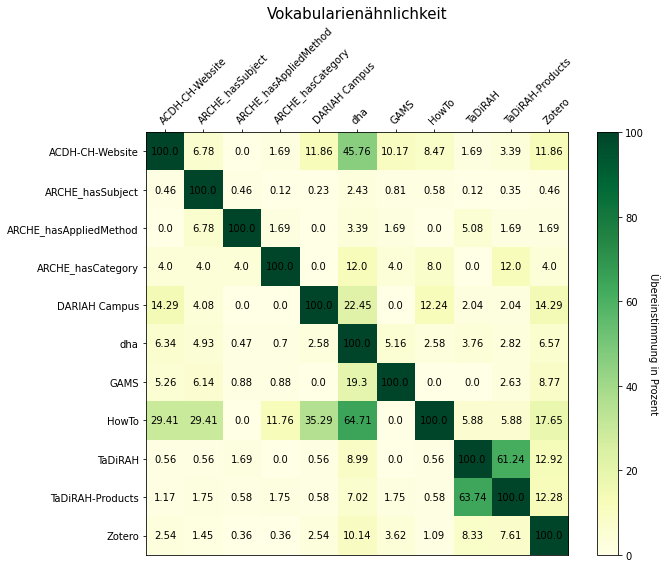

In [81]:
#Heatmap-Visualisierung der prozentualen Vokabularienähnlichkeit

#Zeilen- und Spaltenlabels definieren
zeilen = ["ACDH-CH-Website", "ARCHE_hasSubject", "ARCHE_hasAppliedMethod", "ARCHE_hasCategory", "DARIAH Campus", "dha", "GAMS", "HowTo", "TaDiRAH", "TaDiRAH-Products", "Zotero"]
spalten = zeilen

#Daten definieren
tabelle_proz_zahlen = [] #neue Liste von Listen exkl. Strings notwendig
for zeile in tabelle_proz:
    nur_zahlen = [x for x in zeile if type(x)!=str]
    tabelle_proz_zahlen.append(nur_zahlen)
daten = np.array(tabelle_proz_zahlen)

#Initialisieren von Plots
fig, heatmap = plt.subplots()
im = heatmap.imshow(daten, cmap="YlGn")

#Größe der Abbildung einstellen
fig.set_figheight(8)
fig.set_figwidth(10)

#Labels hinzufügen
heatmap.set_xticks(np.arange(len(spalten)), labels=spalten)
heatmap.set_yticks(np.arange(len(zeilen)), labels=zeilen)

#Spaltenbeschriftung nach oben
heatmap.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

#Spaltenbeschriftung rotieren
plt.setp(heatmap.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

#Loop über Daten --> Werte pro Heatmap-Kästchen anzeigen
for i in range(len(zeilen)):
    for j in range(len(spalten)):
        text = heatmap.text(j, i, daten[i, j], ha="center", va="center", color="black")

#Legende (Colorbar) hinzufügen
legende = heatmap.figure.colorbar(im, ax=heatmap)
legende.ax.set_ylabel(ylabel="Übereinstimmung in Prozent", rotation=-90, va="bottom")

#Titel hinzufügen
heatmap.set_title("Vokabularienähnlichkeit", fontsize=15)

#Verbesserung des Layouts
fig.tight_layout()

plt.show()

### Überlegungen zur automatischen Identifikation weiterer 'Matches' zwischen Vokabularien

aktuell: Wortabgleich mit Ignorieren von Groß-/Kleinschreibung

theoretisch noch denkbar:
- Trennen von mehreren durch Gedankenstriche, Beistriche oder Schrägstriche aneinandergereihten Konzepten in einem Tags (z.B. "archaeological excavation, pottery documentation, photography" (arche_hasAppliedMethod), "computers / computer science" (zotero))
- Lemmatisierung (Plural > Singular; z.B. "conferences" (zotero)
- nur Abgleich von Vokabularien(teilen) der gleichen Sprache (en/de-Unterscheidung je Tag, automatische Übersetzung von Tagsets, die nur in einer Sprache vorhanden sind?)
- formale Ähnlichkeit über Levenstheindistanz = 1 oder <= 2 (rechenintensiv)
- weiteres Cleaning: Entfernen von Punkten, Beistrichen, ...


### Miteinbeziehen von Counts
- bisher Type-Level (distinkte Tags)
- ab hier Token-Level (Verwendungshäufigkeit einzelner Tags)

Counts aktuell für folgende Vokabularien vorhanden:
- ACDH-Website
- ARCHE_hasSubject
- ARCHE_hasAppliedMethod
- DARIAH Campus
- dha
- HowTo

(noch) keine Counts vorhanden für:
- ARCHE_hasCategory
- GAMS
- TaDiRAH
- Zotero [in Arbeit]

In [30]:
#Erstellen von Dictionary mit allen Tagcounts und deren Summe
#aktuell arche_hasCategory noch auskommentiert, da hier noch Count einzuholen

tag_count = {}

for tag in tags:
    if tag in acdh.keys():
        acdh_c = acdh[tag]["count"] #teilweise mehr Informationen in Dictionaries, weshalb zusätzlicher Key notwendig
    else:
        acdh_c = 0
    if tag in arche_hasSubject.keys():
        arche_hasSubject_c = arche_hasSubject[tag]
    else: 
        arche_hasSubject_c = 0
    if tag in arche_hasAppliedMethod.keys():
        arche_hasAppliedMethod_c = arche_hasAppliedMethod[tag]
    else:
        arche_hasAppliedMethod_c = 0
   # if tag in arche_hasCategory.keys():
        #arche_hasCategory_c = arche_hasCategory[tag]
    #else:
        #arche_hasCategory_c = 0
    if tag in dc.keys():
        dc_c = dc[tag]
    else:
        dc_c = 0
    if tag in dha.keys():
        dha_c = dha[tag]
    else:
        dha_c = 0
    if tag in ht.keys():
        ht_c = ht[tag]["count"]
    else:
        ht_c = 0
    sum = int(acdh_c) + int(arche_hasSubject_c) + int(arche_hasAppliedMethod_c) + int(dc_c) + int(dha_c) + int(ht_c) #+ int(arche_hasCategory_c)
    tag_count[tag] = {"acdh": acdh_c, "arche_hasSubject": arche_hasSubject_c, "arche_hasAppliedMethod": arche_hasAppliedMethod_c, "dc": dc_c, "dha":dha_c, "ht": ht_c, "sum": sum} 
                    #"arche_hasCategory": arche_hasCategory_c

In [31]:
#über Priorityqueue die Belege mit den höchsten Count-Summen + zusätzliche Infos über Verteilung ausgeben

import queue
pq = queue.PriorityQueue()

for key in tag_count.keys():
    count = tag_count
    pq.put((-tag_count[key]["sum"], key)) #Minus, da Priorityqueue per Default von niedrig zu hoch ordnet

x = range(1,6) #Anzahl der anzuzeigenden Tags: aktuell Top 5
for n in x:
  element = pq.get()
  toptag = element[1]
  count_toptag = -(element[0])
  print("Platz", n, "- Tag:", toptag, "- Count:", count_toptag)
  print("Verteilung:", tag_count[toptag])
  print()

Platz 1 - Tag: pottery fragments - Count: 11805
Verteilung: {'acdh': 0, 'arche_hasSubject': '11805', 'arche_hasAppliedMethod': 0, 'dc': 0, 'dha': 0, 'ht': 0, 'sum': 11805}

Platz 2 - Tag: photography - Count: 4067
Verteilung: {'acdh': 0, 'arche_hasSubject': 0, 'arche_hasAppliedMethod': '4067', 'dc': 0, 'dha': 0, 'ht': 0, 'sum': 4067}

Platz 3 - Tag: geschichte - Count: 2940
Verteilung: {'acdh': 0, 'arche_hasSubject': '2940', 'arche_hasAppliedMethod': 0, 'dc': 0, 'dha': 0, 'ht': 0, 'sum': 2940}

Platz 4 - Tag: grundbuch - Count: 2940
Verteilung: {'acdh': 0, 'arche_hasSubject': '2940', 'arche_hasAppliedMethod': 0, 'dc': 0, 'dha': 0, 'ht': 0, 'sum': 2940}

Platz 5 - Tag: scanning - Count: 2825
Verteilung: {'acdh': 0, 'arche_hasSubject': 0, 'arche_hasAppliedMethod': '2825', 'dc': 0, 'dha': 0, 'ht': 0, 'sum': 2825}



In [32]:
#Überblick über Verteilung von Tokens (= Tagvergaben) über die verschiedenen Dictionaries
#wie häufig wurden pro Datenquelle Tags vergeben? (d.h. mehrfache Vergabe des gleichen Tags zählt mehrmals)

acdh_tokens = 0
arche_hasSubject_tokens = 0
arche_hasAppliedMethod_tokens = 0
#arche_hasCategory_tokens = 0
dc_tokens = 0
dha_tokens = 0
ht_tokens = 0

for key in tag_count.keys():
    acdh_tokens = acdh_tokens + int(tag_count[key]["acdh"])
    arche_hasSubject_tokens = arche_hasSubject_tokens + int(tag_count[key]["arche_hasSubject"])
    arche_hasAppliedMethod_tokens = arche_hasAppliedMethod_tokens + int(tag_count[key]["arche_hasAppliedMethod"])
    #arche_hasCategory_tokens = arche_hasCategory_tokens + int(tag_count[key]["arche_hasCategory"])
    dc_tokens = dc_tokens + int(tag_count[key]["dc"])
    dha_tokens = dha_tokens + int(tag_count[key]["dha"])
    ht_tokens = ht_tokens + int(tag_count[key]["ht"])

print("ACDH-CH-Website:", acdh_tokens)
print("ARCHE_hasSubject:", arche_hasSubject_tokens)
print("ARCHE_hasAppliedMethod:", arche_hasAppliedMethod_tokens)
#print("ARCHE_hasCategory:", arche_hasCategory_tokens)
print("DARIAH Campus:", dc_tokens)
print("dha:", dha_tokens)
print("ACDH-CH HowTo:", ht_tokens)
    

ACDH-CH-Website: 481
ARCHE_hasSubject: 54332
ARCHE_hasAppliedMethod: 9703
DARIAH Campus: 295
dha: 1444
ACDH-CH HowTo: 16


### Speicherung der Ergebnisse

In [33]:
#Speicherung des Vergleichs als .csv (aktuell nur Taglevel, exklusive Vocab-Matrix, Counts etc)

with open("Vokabularienvergleich.csv", "w", newline = "", encoding = "utf-8") as datei:
    writer = csv.writer(datei, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["Tag", "ACDH-CH-Website", "ARCHE_hasSubject", "ARCHE_hasAppliedMethod", "ARCHE_hasCategory", "DARIAH Campus", "dha", "ACDH-CH HowTo", "Summe"])
    for key in vgl.keys():
        writer.writerow([key, vgl[key]["count_acdh"], vgl[key]["count_arche_hasSubject"], vgl[key]["count_arche_hasAppliedMethod"], vgl[key]["count_arche_hasCategory"], vgl[key]["count_dc"], vgl[key]["count_dha"], vgl[key]["count_ht"], vgl[key]["sum"]])

#Speicherung als Dictionary

with open("Vokabularienvergleich.json", "w", encoding = "utf-8") as datei:
    json.dump(vgl, datei, ensure_ascii = False)